# Lezione 21 - Scelta del Numero di Cluster

## Sezione 1 - Titolo e obiettivi

---

## Mappa della lezione

| Sezione | Contenuto | Tempo stimato |
|---------|-----------|---------------|
| 1 | Titolo, obiettivi, il problema di K | 5 min |
| 2 | Teoria profonda: Elbow, Silhouette, Gap | 20 min |
| 3 | Schema mentale: flowchart scelta K | 5 min |
| 4 | Demo: confronto metodi su dati sintetici | 20 min |
| 5 | Esercizi risolti + errori comuni | 20 min |
| 6 | Conclusione operativa | 10 min |
| 7 | Checklist di fine lezione + glossario | 5 min |
| 8 | Changelog didattico | 2 min |

---

## Obiettivi della lezione

Al termine di questa lezione sarai in grado di:

| # | Obiettivo | Verifica |
|---|-----------|----------|
| 1 | Interpretare la curva Elbow e trovare il gomito | Sai perché l'inertia scende sempre? |
| 2 | Calcolare e leggere Silhouette Score | Sai che range [-1, +1] significa? |
| 3 | Costruire e interpretare Silhouette Plot | Sai individuare cluster deboli? |
| 4 | Applicare (opzionale) Gap Statistic | Conosci l'idea del confronto con random? |
| 5 | Combinare più criteri per scegliere K | Sai cosa fare se i metodi discordano? |

---

## Il problema centrale: K non è dato

> K-Means funziona con qualsiasi K. Ma solo alcuni valori rivelano la struttura reale.

| K troppo piccolo | K giusto | K troppo grande |
|------------------|----------|-----------------|
| Cluster eterogenei | Gruppi stabili | Over-segmentazione |
| Informazione persa | Interpretabili | Cluster senza significato |
| Inertia alta | Inertia al "gomito" | Inertia molto bassa (overfitting) |

---

## I 3 metodi principali (sintesi)

| Metodo | Cosa misura | Pro | Contro |
|--------|-------------|-----|--------|
| **Elbow** | Inertia (WCSS) | Veloce, intuitivo | Gomito spesso ambiguo |
| **Silhouette** | Coesione/separazione | Robusto, interpretabile | Tende a preferire K piccoli |
| **Gap Statistic** | Confronto con random | Statisticamente fondato | Costoso computazionalmente |

**Regola pratica:** usa Elbow + Silhouette insieme. Gap Statistic come terzo parere se necessario.

---

## Prerequisiti minimi

| Concetto | Dove lo trovi | Verifica |
|----------|---------------|----------|
| K-Means | Lezione 20 | Sai cos'è l'inertia? |
| Distanza euclidea | Lezione 19-20 | Sai calcolare distanze? |
| StandardScaler | Lezione 13, 20 | Sai perché scalare? |

**Micro-checkpoint prerequisiti:**
```python
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
print("OK!" if callable(silhouette_score) else "Rivedi sklearn.metrics")
```

---

## Outcome atteso

Al termine saprai:
- Applicare più metodi sulla stessa griglia di K
- Leggere e confrontare i segnali
- Risolvere casi ambigui con parsimonia
- Motivare la scelta di K con spiegazioni chiare agli stakeholder

## Sezione 2 - Teoria profonda

### 1.1 Perche scegliere K e critico
- K troppo piccolo: cluster eterogenei, informazione persa.
- K troppo grande: over-segmentazione, cluster senza significato.
- K appropriato: gruppi stabili e interpretabili. K-Means non ti dice quale K usare: serve una metrica esterna.

### 1.2 Approccio multi-criterio
Nessun metodo e perfetto. Combina piu segnali (Elbow, Silhouette, Gap, interpretabilita) e scegli il K piu semplice che resta coerente con il business.


### 1.3 Metodo del Gomito (Elbow)

**Cosa misura**: l'inertia (WCSS) per K=1..K_max. L'inertia diminuisce sempre aumentando K.

**Formula (ricordo)**: $\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2$. E la somma delle distanze quadrate dai punti al proprio centroide.

**Come si usa**
1. Calcola inertia per una griglia di K.
2. Traccia la curva inertia vs K.
3. Cerca il gomito: dopo quel punto i miglioramenti sono marginali.

**Quando e utile**: veloce, intuitivo, funziona bene con cluster ben separati. **Limite**: il gomito puo essere poco chiaro.


### 1.4 Silhouette Score

**Cosa misura**: quanto ogni punto e piu vicino al proprio cluster che agli altri.

**Formula per un punto i**: $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$, dove:
- $a(i)$ = distanza media di i dai punti del suo cluster (coesione).
- $b(i)$ = distanza media di i dal cluster piu vicino (separazione).

**Range e lettura**
- Da -1 a +1.
- Circa +1: punto ben assegnato; circa 0: al confine; negativo: probabilmente nel cluster sbagliato.

**Score globale**: media di tutti i $s(i)$. Tipico: >0.7 ottimo, 0.5-0.7 buono, 0.25-0.5 moderato, <0.25 debole.

**Quando usarlo**: per confrontare K diversi e per valutare qualita generale. Limite: tende a preferire K piccoli se i cluster sono sbilanciati.


### 1.5 Silhouette Plot

**Cosa mostra**: distribuzione dei silhouette score per cluster. Scopre problemi che la media nasconde.

**Come leggerlo**
- Larghezza simile tra cluster: nessun gruppo minuscolo o schiacciato.
- Pochi valori negativi: poche assegnazioni sbagliate.
- Barre sopra la media globale: cluster solidi.

**Quando usarlo**: sempre quando Elbow e Silhouette non concordano, o quando vuoi capire quale cluster e debole.


### 1.6 Gap Statistic

**Idea**: confronta l'inertia dei dati reali con quella di dati uniformi random nello stesso range. Se i dati hanno struttura reale, l'inertia reale e molto piu bassa.

**Definizione**: $\text{Gap}(K) = \mathbb{E}[\log(W_K^*)] - \log(W_K)$, dove $W_K$ e l'inertia sui dati e $W_K^*$ la media dell'inertia su B dataset random.

**Scelta di K**: scegli il K piu piccolo tale che $\text{Gap}(K) \geq \text{Gap}(K+1) - s_{K+1}$ (s_{K+1} = dev. standard delle simulazioni).

**Quando usarla**: quando vuoi un criterio piu statistico. Limiti: piu costosa (molte simulazioni) e non inclusa nativamente in sklearn.


## Sezione 3 - Schema mentale e decision map

Workflow per scegliere K (dopo aver scalato i dati):

```
DATI SCALATI
    |
    +--> Elbow: trova il gomito (K1)
    +--> Silhouette score: trova il massimo (K2)
    +--> Silhouette plot: verifica cluster problematici
    +--> Gap statistic (opzionale): verifica robustezza
           |
           v
    I metodi concordano?
      |               si          no
      |          |
      v          v
   usa K1   preferisci il K piu semplice
             (leggi silhouette plot e contesto)
```

Checklist decisionale rapida
- Elbow calcolato e gomito identificabile? Se ambiguo, annotalo.
- Silhouette calcolata per piu K? Confronta con Elbow.
- Silhouette plot analizzato? Segna cluster sottili o con valori negativi.
- Interpretabilita: il K scelto ha senso per il business? Se no, riduci K.


## Sezione 4 - Notebook dimostrativo

### Perche questo passo (Demo 1 - Elbow)
Vogliamo vedere come l'inertia decresce con K su dati con 4 cluster noti. Ci aspettiamo un gomito vicino a K=4: un buon esempio di curva chiara.


Dataset: 300 punti, 2 feature. Inertia decresce con K: prime 3 [599.9999999999999, 312.73346374144177, 66.7044500868346]...


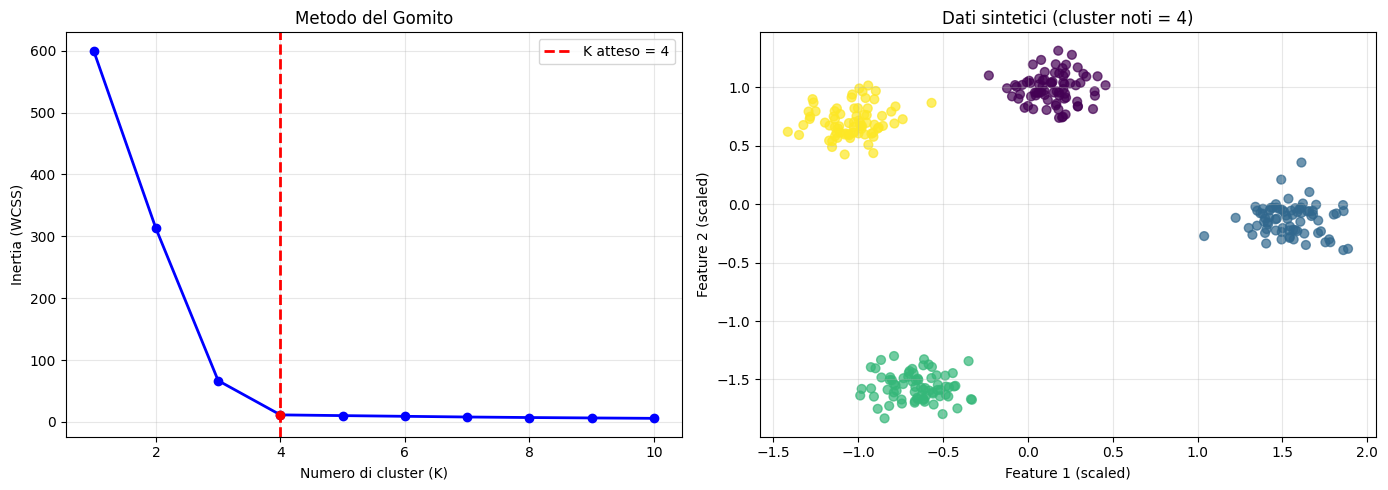

In [11]:
# Demo 1: Elbow Method su dati sintetici (gomito atteso a K=4)
# Intento: mostrare l'andamento dell'inertia e verificare dove la curva piega.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# Generiamo dati con 4 cluster ben separati
np.random.seed(42)
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
assert X.ndim == 2 and X.shape[1] == 2, "Atteso array 2D con 2 feature"
assert not np.isnan(X).any(), "Dati contengono NaN"

# Scaling: StandardScaler rende confrontabili le feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
assert X_scaled.shape == X.shape, "Shape inattesa dopo scaling"

# Calcoliamo inertia per K=1..10
K_range = range(1, 11)
inertias = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

print(f"Dataset: {X.shape[0]} punti, {X.shape[1]} feature. Inertia decresce con K: prime 3 {inertias[:3]}...")

# Visualizzazione curva Elbow e cluster veri
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Numero di cluster (K)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Metodo del Gomito')
axes[0].axvline(x=4, color='red', linestyle='--', linewidth=2, label='K atteso = 4')
axes[0].scatter([4], [inertias[3]], color='red', zorder=5)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

scatter = axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, cmap='viridis', s=40, alpha=0.7)
axes[1].set_title('Dati sintetici (cluster noti = 4)')
axes[1].set_xlabel('Feature 1 (scaled)')
axes[1].set_ylabel('Feature 2 (scaled)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check qualitativo: ci aspettiamo un gomito netto intorno a K=4.


### Perche questo passo (Demo 2 - Silhouette score)
Usiamo lo stesso dataset per confrontare Elbow e Silhouette. Ci aspettiamo che il massimo del silhouette cada su K=4, confermando il gomito.


Miglior K per silhouette: 4 (score=0.839). Atteso vicino a 4.


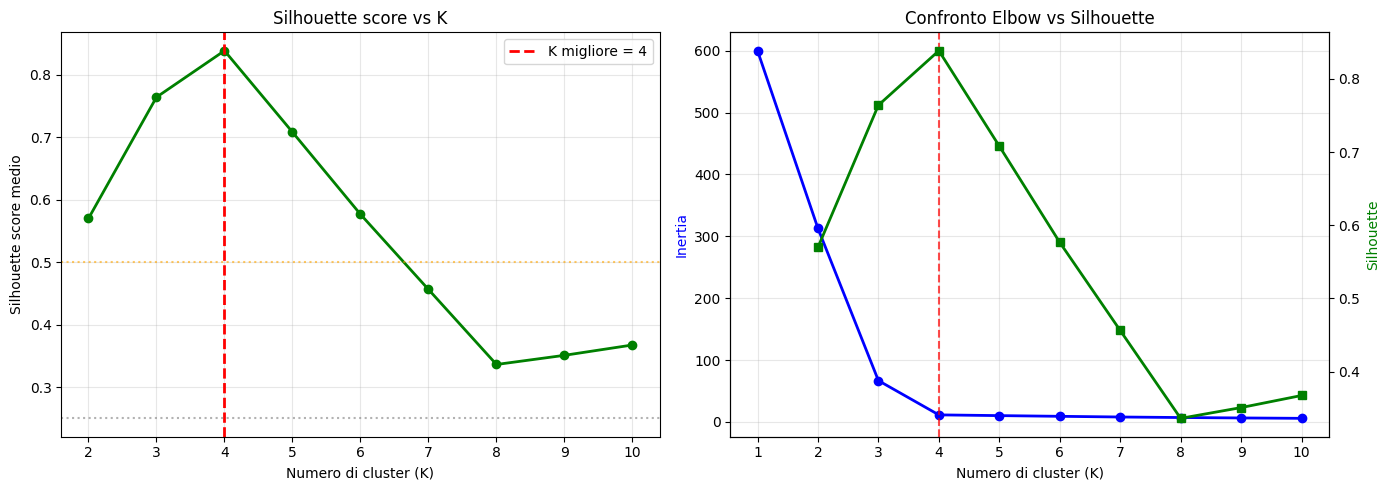

In [12]:
# Demo 2: Silhouette Score su griglia di K (verifica concordanza con Elbow)
# Intento: confrontare il picco del silhouette con il gomito dell'inertia.

from sklearn.metrics import silhouette_score

# Sanity check sulla disponibilita di X_scaled
assert 'X_scaled' in globals(), "Esegui prima Demo 1 per generare e scalare i dati"

K_range_sil = range(2, 11)  # silhouette richiede almeno 2 cluster
silhouette_scores = []

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

best_k = list(K_range_sil)[int(np.argmax(silhouette_scores))]
best_score = max(silhouette_scores)
print(f"Miglior K per silhouette: {best_k} (score={best_score:.3f}). Atteso vicino a 4.")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(list(K_range_sil), silhouette_scores, 'go-', linewidth=2, markersize=6)
axes[0].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'K migliore = {best_k}')
axes[0].set_xlabel('Numero di cluster (K)')
axes[0].set_ylabel('Silhouette score medio')
axes[0].set_title('Silhouette score vs K')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].axhline(y=0.5, color='orange', linestyle=':', alpha=0.6, label='Struttura buona (~0.5)')
axes[0].axhline(y=0.25, color='grey', linestyle=':', alpha=0.6, label='Struttura debole (~0.25)')

# Confronto Elbow (inertia) e Silhouette sullo stesso asse X
ax2 = axes[1]
ax2_twin = ax2.twinx()
ax2.plot(list(K_range), inertias, 'b-o', linewidth=2, markersize=6, label='Inertia (Elbow)')
ax2_twin.plot(list(K_range_sil), silhouette_scores, 'g-s', linewidth=2, markersize=6, label='Silhouette')
ax2.axvline(x=4, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Numero di cluster (K)')
ax2.set_ylabel('Inertia', color='blue')
ax2_twin.set_ylabel('Silhouette', color='green')
ax2.set_title('Confronto Elbow vs Silhouette')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(list(K_range))

plt.tight_layout()
plt.show()

# Check: ci aspettiamo concordanza tra gomito (K~4) e massimo silhouette (K~4).


### Perche questo passo (Demo 3 - Silhouette plot)
La media del silhouette puo nascondere cluster deboli. Visualizziamo la distribuzione per K=3,4,5 per capire quale configurazione ha cluster piu equilibrati.


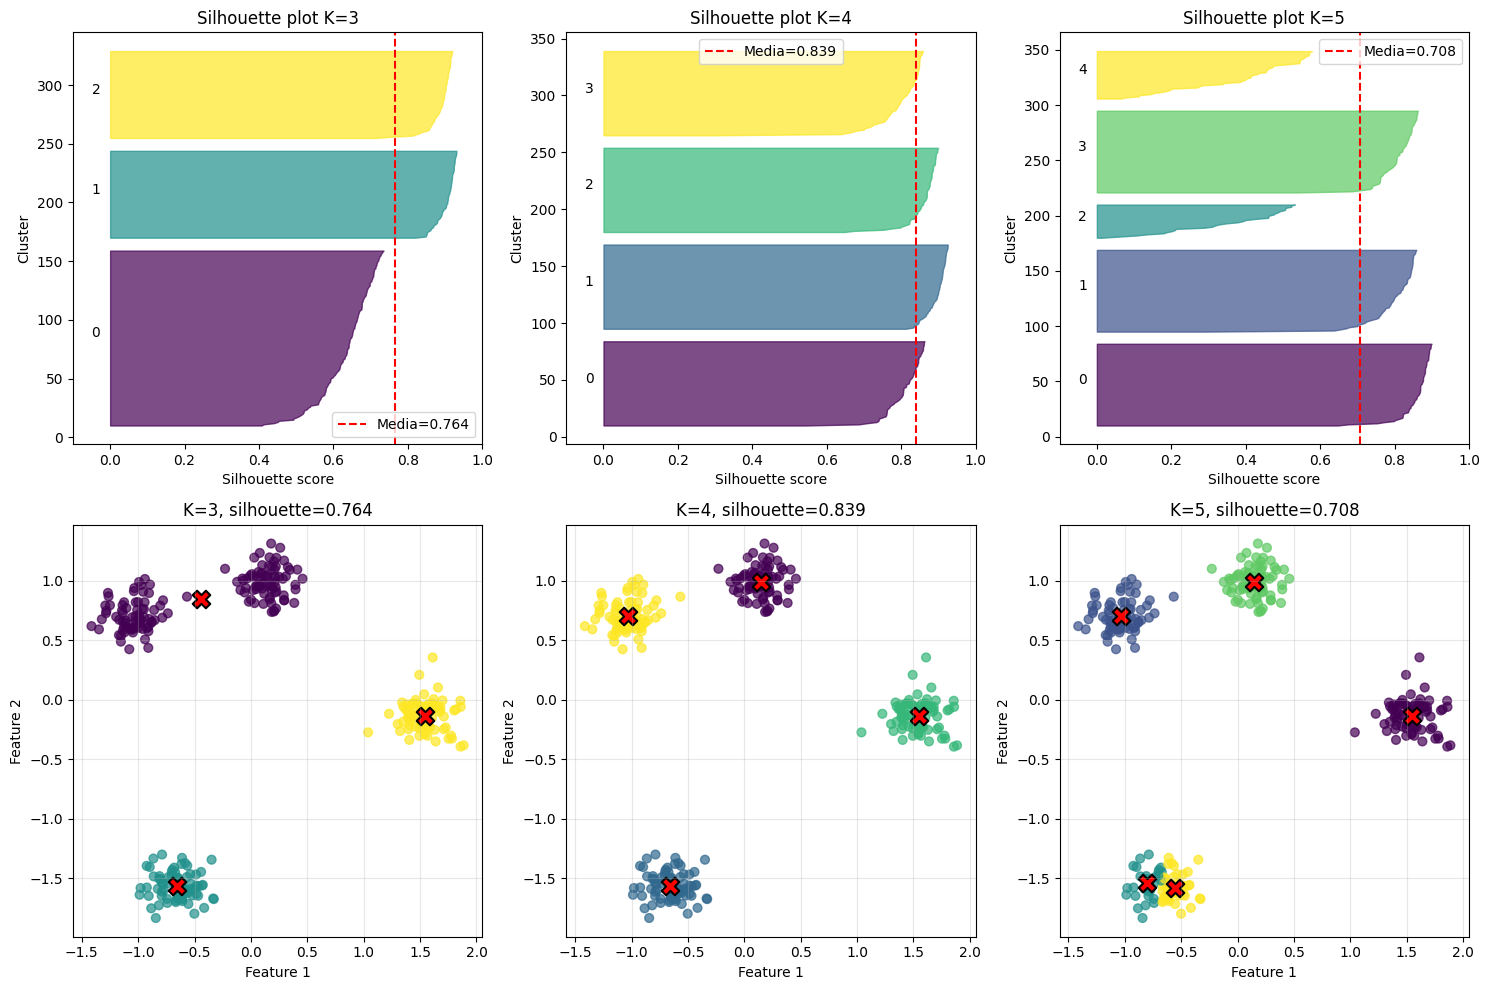

In [13]:
# Demo 3: Silhouette plot per valutare la qualita per cluster
# Intento: controllare se singoli cluster risultano deboli per diversi K.

from sklearn.metrics import silhouette_samples

assert 'X_scaled' in globals(), "Esegui prima le demo precedenti"

def plot_silhouette(X, n_clusters, ax, title):
    '''
    Disegna un silhouette plot per un dato K.
    Input: X (array 2D), n_clusters (int), ax (Axes), title (str).
    Output: (labels, silhouette_avg). Errori tipici: cluster vuoti o dati con NaN.
    '''
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_vals = silhouette_samples(X, labels)
    sil_avg = silhouette_score(X, labels)
    y_lower = 10
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    for i in range(n_clusters):
        cluster_vals = sil_vals[labels == i]
        cluster_vals.sort()
        size = cluster_vals.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals,
                         facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10
    ax.axvline(x=sil_avg, color='red', linestyle='--', label=f'Media={sil_avg:.3f}')
    ax.set_xlabel('Silhouette score')
    ax.set_ylabel('Cluster')
    ax.set_title(title)
    ax.set_xlim([-0.1, 1])
    ax.legend()
    return labels, sil_avg

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Riga superiore: silhouette plots
for idx, k in enumerate([3, 4, 5]):
    plot_silhouette(X_scaled, k, axes[0, idx], f'Silhouette plot K={k}')

# Riga inferiore: scatter per visualizzare cluster
for idx, k in enumerate([3, 4, 5]):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    axes[1, idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=40, alpha=0.7)
    axes[1, idx].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                         c='red', marker='X', s=160, edgecolors='black', linewidths=1.5)
    axes[1, idx].set_title(f'K={k}, silhouette={score:.3f}')
    axes[1, idx].set_xlabel('Feature 1')
    axes[1, idx].set_ylabel('Feature 2')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check: preferiamo K con barre larghe e poche zone negative; ci aspettiamo K=4 migliore.


### Perche questo passo (Demo 4 - Gap statistic)
Introduciamo un criterio piu statistico per confrontare Elbow e Silhouette. Il gap mette a confronto i dati reali con dati uniformi random per capire se esiste davvero struttura.


Gap statistic calcolata fino a K=8. Primo K che soddisfa la regola: 4


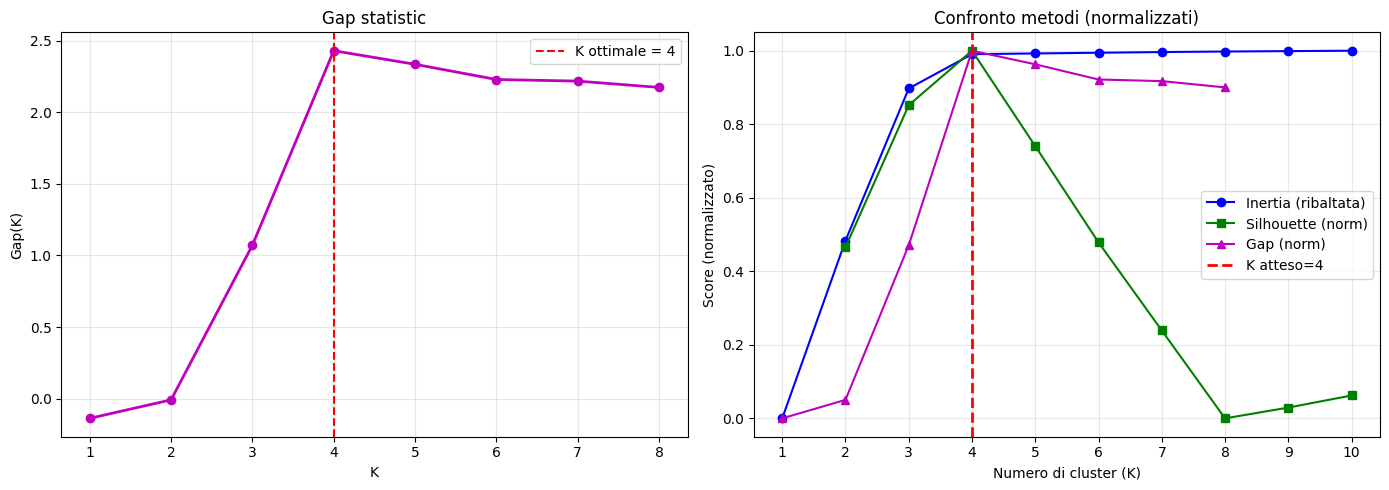

In [14]:
# Demo 4: Gap Statistic (implementazione manuale)
# Intento: stimare K confrontando inertia reale con inertia su dati uniformi.

assert 'X_scaled' in globals(), "Esegui prima le demo precedenti"

def compute_gap_statistic(X, k_max=10, n_refs=10):
    '''
    Calcola Gap(K) per K=1..k_max.
    Input: X array 2D scalato; k_max int; n_refs repliche random.
    Output: gaps (list), sk (std list), optimal_k (int).
    Errori tipici: k_max troppo grande rispetto a n_samples; presenza di NaN.
    '''
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    gaps, sks = [], []
    for k in range(1, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        log_wk = np.log(km.inertia_)
        ref_logs = []
        for _ in range(n_refs):
            X_rand = np.random.uniform(mins, maxs, size=X.shape)
            km_ref = KMeans(n_clusters=k, random_state=None, n_init=10)
            km_ref.fit(X_rand)
            ref_logs.append(np.log(km_ref.inertia_))
        ref_mean = np.mean(ref_logs)
        ref_std = np.std(ref_logs) * np.sqrt(1 + 1/n_refs)
        gaps.append(ref_mean - log_wk)
        sks.append(ref_std)
    optimal_k = 1
    for k in range(1, k_max):
        if gaps[k-1] >= gaps[k] - sks[k]:
            optimal_k = k
            break
    return gaps, sks, optimal_k

# Calcolo gap per il dataset sintetico
k_max = 8
gaps, sks, optimal_k = compute_gap_statistic(X_scaled, k_max=k_max, n_refs=8)
print(f"Gap statistic calcolata fino a K={k_max}. Primo K che soddisfa la regola: {optimal_k}")

# Visualizzazione gap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(1, k_max+1), gaps, 'mo-', linewidth=2, markersize=6)
axes[0].set_xlabel('K')
axes[0].set_ylabel('Gap(K)')
axes[0].set_title('Gap statistic')
axes[0].axvline(x=optimal_k, color='red', linestyle='--', label=f'K ottimale = {optimal_k}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confronto normalizzato tra inertia, silhouette, gap
inert_norm = (np.array(inertias) - np.min(inertias)) / (np.max(inertias) - np.min(inertias))
sil_norm = (np.array(silhouette_scores) - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
gap_norm = (np.array(gaps) - np.min(gaps)) / (np.max(gaps) - np.min(gaps))
axes[1].plot(range(1, len(inert_norm)+1), 1 - inert_norm, 'b-o', label='Inertia (ribaltata)')
axes[1].plot(range(2, len(sil_norm)+2), sil_norm, 'g-s', label='Silhouette (norm)')
axes[1].plot(range(1, len(gap_norm)+1), gap_norm, 'm-^', label='Gap (norm)')
axes[1].axvline(x=4, color='red', linestyle='--', linewidth=2, label='K atteso=4')
axes[1].set_xlabel('Numero di cluster (K)')
axes[1].set_ylabel('Score (normalizzato)')
axes[1].set_title('Confronto metodi (normalizzati)')
axes[1].set_xticks(range(1, 11))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check: Elbow, Silhouette e Gap dovrebbero suggerire K circa 4.


### Perche questo passo (Demo 5 - Caso ambiguo)
Mostriamo un dataset con cluster sovrapposti. Qui Elbow e Silhouette sono meno chiari: usiamo il silhouette plot e il principio di parsimonia per scegliere K.


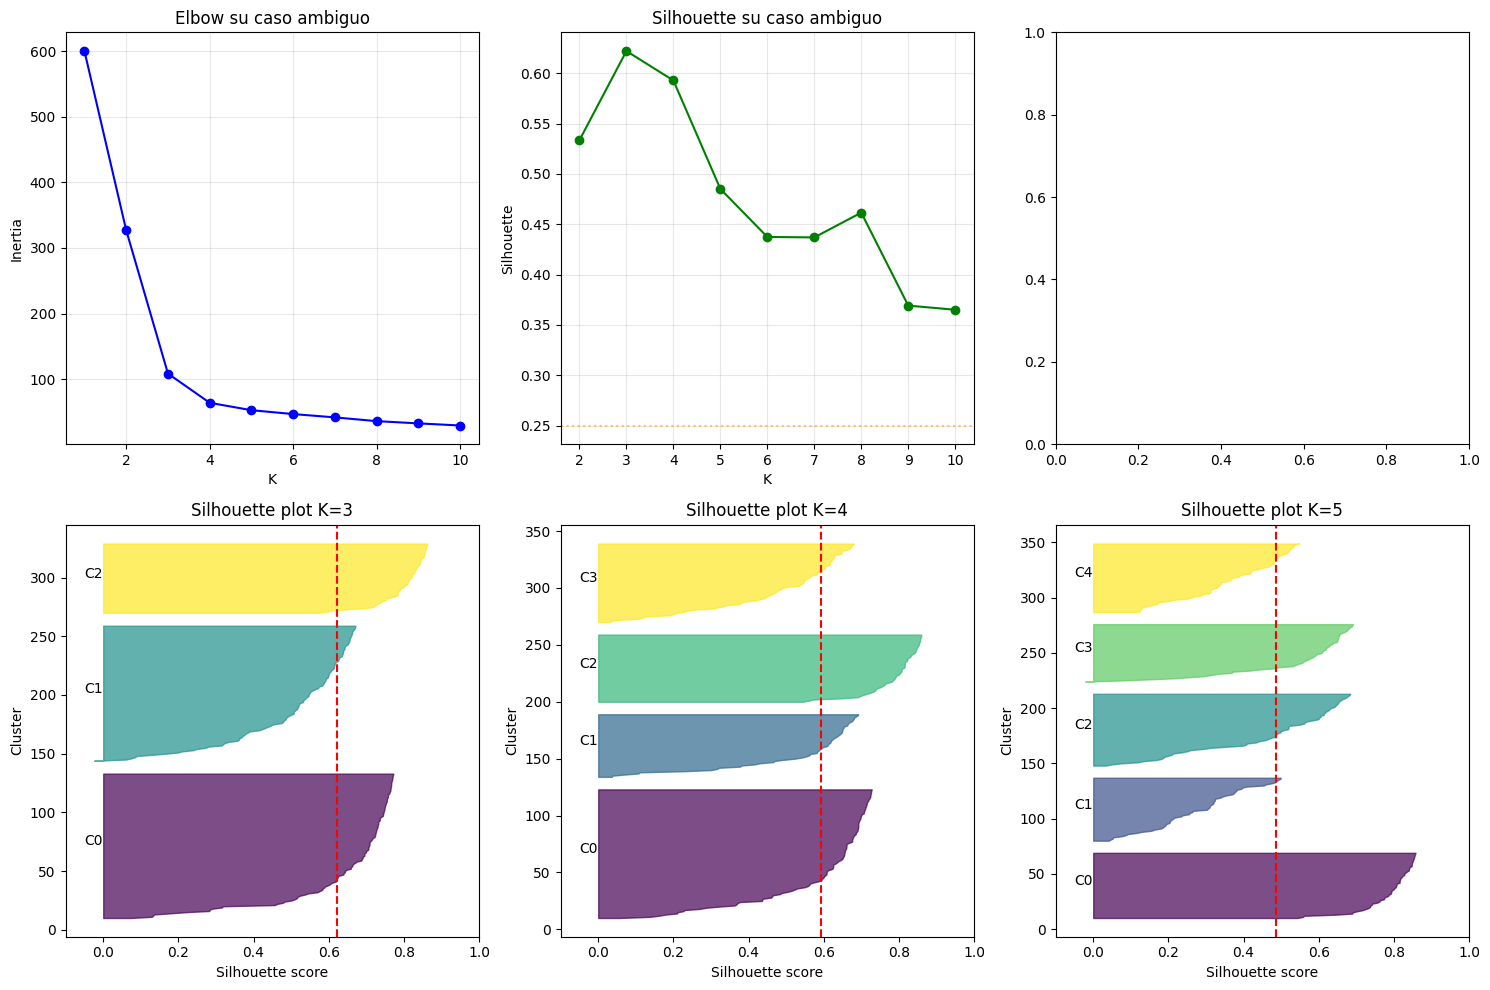

In [15]:
# Demo 5: caso ambiguo con cluster sovrapposti
# Intento: vedere cosa succede quando i metodi non danno un segnale netto.

np.random.seed(42)
X_hard, _ = make_blobs(n_samples=300, centers=5, cluster_std=1.8, random_state=42)
X_hard_scaled = StandardScaler().fit_transform(X_hard)
assert not np.isnan(X_hard_scaled).any(), "Dati contengono NaN"

# Elbow e silhouette su dati difficili
K_range = range(1, 11)
inertias_hard = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_hard_scaled)
    inertias_hard.append(km.inertia_)

K_range_sil = range(2, 11)
sil_scores_hard = []
for k in K_range_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_hard_scaled)
    sil_scores_hard.append(silhouette_score(X_hard_scaled, labels))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].plot(K_range, inertias_hard, 'bo-')
axes[0, 0].set_title('Elbow su caso ambiguo')
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(list(K_range_sil), sil_scores_hard, 'go-')
axes[0, 1].set_title('Silhouette su caso ambiguo')
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Silhouette')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.25, color='orange', linestyle=':', alpha=0.6)

# Silhouette plot per K=3,4,5 per decidere
from sklearn.metrics import silhouette_samples

for idx, k in enumerate([3, 4, 5]):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_hard_scaled)
    sil_vals = silhouette_samples(X_hard_scaled, labels)
    y_lower = 10
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    ax = axes[1, idx]
    for i in range(k):
        vals = sil_vals[labels == i]
        vals.sort()
        size = len(vals)
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                         facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        ax.text(-0.05, y_lower + size/2, f'C{i}')
        y_lower = y_upper + 10
    ax.axvline(x=np.mean(sil_vals), color='red', linestyle='--')
    ax.set_title(f'Silhouette plot K={k}')
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Silhouette score')
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

# Nota interpretativa: se i metodi non concordano, preferisci il K piu semplice (es. 3) salvo esigenze di business.


## Sezione 5 - Esercizi guidati (step by step)

### Perche questo esercizio (21.1)
Costruiamo una funzione riutilizzabile che combina Elbow e Silhouette in un unico report. Obiettivo: automatizzare i calcoli mantenendo i controlli di qualita (shape e NaN).


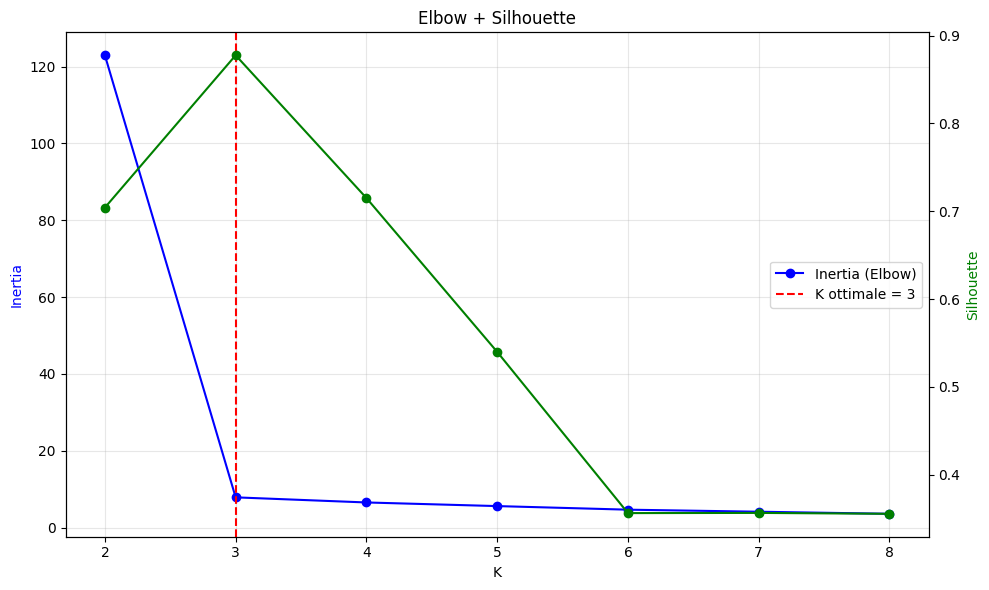

Risultati (k_min=2, k_max=8):
K     Inertia      Silhouette  
--------------------------------
2     122.95       0.704        
3     7.86         0.878        <- migliore
4     6.53         0.715        
5     5.59         0.540        
6     4.66         0.356        
7     4.12         0.356        
8     3.58         0.355        
Raccomandazione: K = 3 (silhouette=0.878)
Test: la funzione trova K=3 (atteso circa 3)


In [16]:
# Esercizio 21.1 - funzione per Elbow + Silhouette
# Intento: creare una funzione riutilizzabile con controlli base e grafico doppio asse.

import numpy as np

def analisi_k_ottimale(X, k_min=2, k_max=10):
    '''
    Calcola inertia e silhouette per K in [k_min, k_max].
    Input: X (array 2D scalato), k_min>=2, k_max>k_min.
    Output: k_ottimale (int) secondo silhouette.
    '''
    assert X.ndim == 2, "X deve essere 2D"
    assert not np.isnan(X).any(), "X contiene NaN"
    K_range = range(k_min, k_max + 1)
    inertias, silhouettes = [], []
    for k in K_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    k_ottimale = list(K_range)[int(np.argmax(silhouettes))]
    best_sil = max(silhouettes)

    # Visualizzazione
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(list(K_range), inertias, 'bo-', label='Inertia (Elbow)')
    ax2.plot(list(K_range), silhouettes, 'go-', label='Silhouette')
    ax1.axvline(x=k_ottimale, color='red', linestyle='--', label=f'K ottimale = {k_ottimale}')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Inertia', color='blue')
    ax2.set_ylabel('Silhouette', color='green')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Elbow + Silhouette')
    ax1.legend(loc='center right')
    plt.xticks(list(K_range))
    plt.tight_layout()
    plt.show()

    # Report tabellare
    print(f"Risultati (k_min={k_min}, k_max={k_max}):")
    print(f"{'K':<5} {'Inertia':<12} {'Silhouette':<12}")
    print('-'*32)
    for k, inert, sil in zip(K_range, inertias, silhouettes):
        marker = '<- migliore' if k == k_ottimale else ''
        print(f"{k:<5} {inert:<12.2f} {sil:<12.3f} {marker}")
    print(f"Raccomandazione: K = {k_ottimale} (silhouette={best_sil:.3f})")
    return k_ottimale

# Test rapido con dati sintetici a 3 cluster
X_test, _ = make_blobs(n_samples=200, centers=3, cluster_std=0.8, random_state=42)
X_test_scaled = StandardScaler().fit_transform(X_test)
assert X_test_scaled.shape[0] == 200
k_risultato = analisi_k_ottimale(X_test_scaled, k_min=2, k_max=8)
print(f"Test: la funzione trova K={k_risultato} (atteso circa 3)")


### Perche questo esercizio (21.2)
Alleniamo la lettura del silhouette plot: la funzione deve evidenziare cluster problematici (silhouette media bassa) e fornire statistiche sintetiche.


Cluster | N punti | Sil media | Sil min | Flag problema
-------------------------------------------------------
0       150      0.635     0.023    OK
1       46       0.661     0.111    OK
2       54       0.465     -0.056   OK


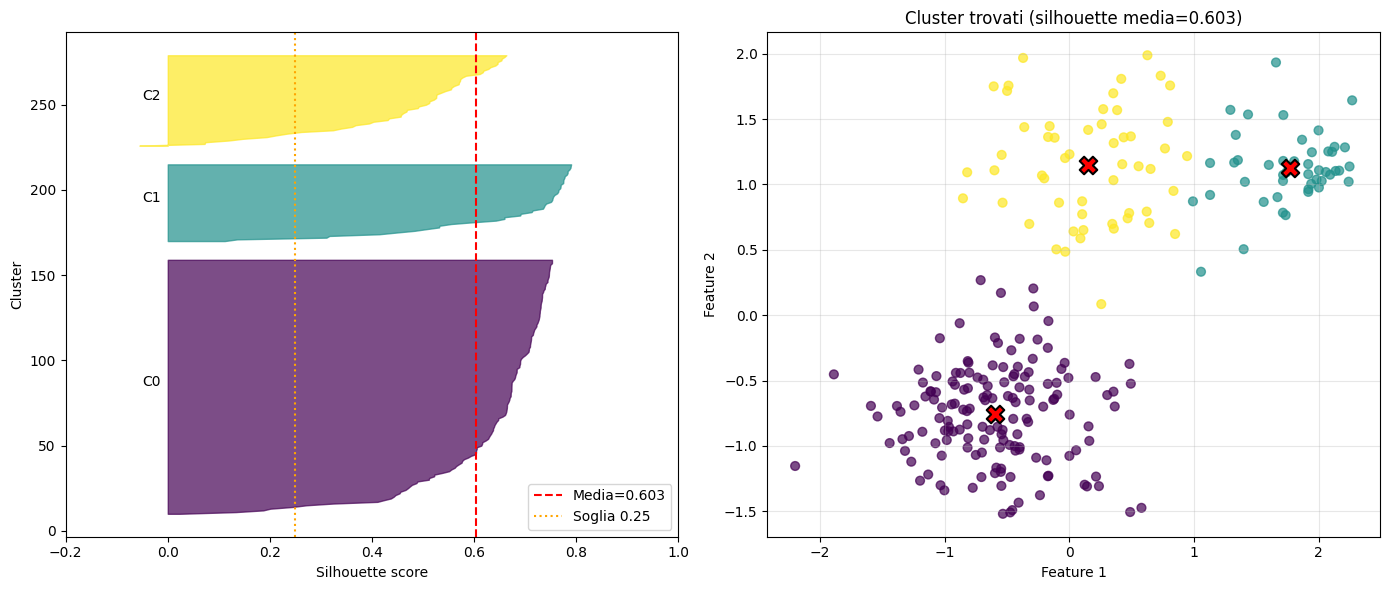

Nessun cluster problematico individuato.


{0: {'n_punti': 150,
  'sil_mean': np.float64(0.6351230351653118),
  'sil_min': np.float64(0.02277843949309697),
  'sil_max': np.float64(0.7524740399051033),
  'problematico': np.False_},
 1: {'n_punti': 46,
  'sil_mean': np.float64(0.6611151554560566),
  'sil_min': np.float64(0.11144752655476467),
  'sil_max': np.float64(0.7899374258095826),
  'problematico': np.False_},
 2: {'n_punti': 54,
  'sil_mean': np.float64(0.4647128966166307),
  'sil_min': np.float64(-0.05552909412701439),
  'sil_max': np.float64(0.6630387956612622),
  'problematico': np.False_}}

In [17]:
# Esercizio 21.2 - funzione per silhouette plot dettagliato
# Intento: evidenziare cluster problematici con silhouette media < 0.25.

import numpy as np

def visualizza_silhouette_clusters(X, k):
    '''
    Disegna silhouette plot e restituisce statistiche per cluster.
    Input: X (array 2D scalato), k (int >=2).
    Output: dict cluster -> statistiche.
    '''
    assert X.ndim == 2, "X deve essere 2D"
    assert not np.isnan(X).any(), "X contiene NaN"

    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_vals = silhouette_samples(X, labels)
    sil_avg = silhouette_score(X, labels)

    # Statistiche per cluster
    cluster_stats = {}
    print(f"Cluster | N punti | Sil media | Sil min | Flag problema")
    print('-'*55)
    for i in range(k):
        vals = sil_vals[labels == i]
        stats = {
            'n_punti': len(vals),
            'sil_mean': vals.mean(),
            'sil_min': vals.min(),
            'sil_max': vals.max(),
            'problematico': vals.mean() < 0.25
        }
        cluster_stats[i] = stats
        flag = 'PROBLEMA' if stats['problematico'] else 'OK'
        print(f"{i:<7} {stats['n_punti']:<8} {stats['sil_mean']:<9.3f} {stats['sil_min']:<8.3f} {flag}")

    # Visualizzazione
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    y_lower = 10
    for i in range(k):
        vals = sil_vals[labels == i]
        vals.sort()
        size = len(vals)
        y_upper = y_lower + size
        axes[0].fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                              facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        axes[0].text(-0.05, y_lower + 0.5*size, f'C{i}')
        y_lower = y_upper + 10
    axes[0].axvline(x=sil_avg, color='red', linestyle='--', label=f'Media={sil_avg:.3f}')
    axes[0].axvline(x=0.25, color='orange', linestyle=':', label='Soglia 0.25')
    axes[0].set_xlabel('Silhouette score')
    axes[0].set_ylabel('Cluster')
    axes[0].set_xlim([-0.2, 1])
    axes[0].legend(loc='lower right')

    axes[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, alpha=0.7)
    axes[1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                    c='red', marker='X', s=160, edgecolors='black', linewidths=1.5)
    axes[1].set_title(f'Cluster trovati (silhouette media={sil_avg:.3f})')
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    problematici = [i for i, s in cluster_stats.items() if s['problematico']]
    if problematici:
        print(f"Cluster problematici (silhouette media < 0.25): {problematici}")
    else:
        print("Nessun cluster problematico individuato.")
    return cluster_stats

# Test con cluster di dimensioni diverse
np.random.seed(42)
cluster1 = np.random.randn(150, 2) + np.array([0, 0])
cluster2 = np.random.randn(30, 2) * 0.5 + np.array([5, 5])
cluster3 = np.random.randn(70, 2) * 1.2 + np.array([2, 5])
X_unbalanced = np.vstack([cluster1, cluster2, cluster3])
X_unbalanced_scaled = StandardScaler().fit_transform(X_unbalanced)
visualizza_silhouette_clusters(X_unbalanced_scaled, k=3)


### Perche questo esercizio (21.3)
Applichiamo i metodi a un mini dataset reale (soddisfazione, frequenza, spesa). Obiettivo: seguire il flusso completo e motivare la scelta di K con dati e grafici.


Dataset iniziale (describe):
       soddisfazione  frequenza  spesa
count           20.0       20.0   20.0
mean             5.5        3.2  119.5
std              2.7        1.9   77.7
min              1.0        1.0   25.0
25%              3.0        1.0   48.8
50%              6.0        3.0   95.0
75%              8.0        5.0  192.5
max              9.0        6.0  250.0
Miglior K per silhouette: 2


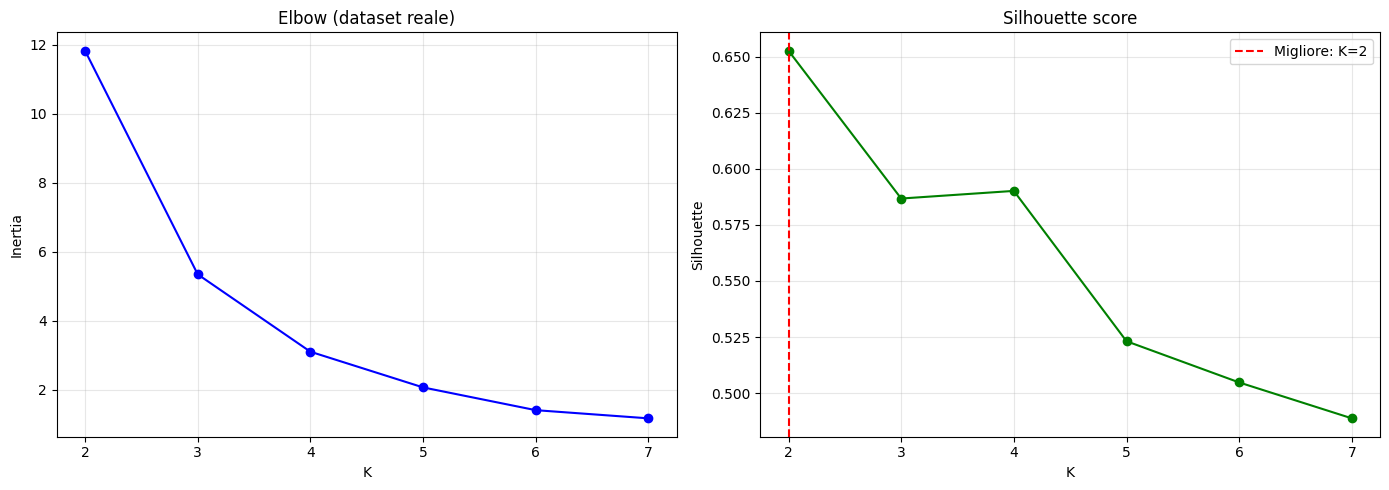

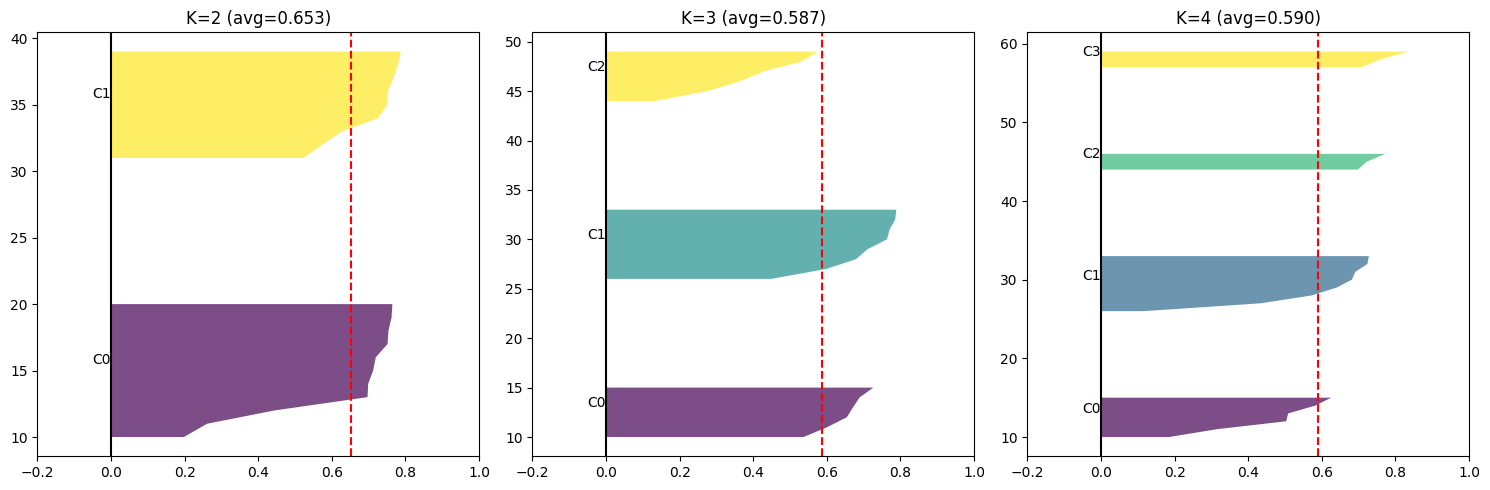

Cluster scelto: 2
Profili medi per cluster:
         soddisfazione  frequenza  spesa
cluster                                 
0                  3.5        1.7   55.5
1                  8.0        5.0  197.8


In [18]:
# Esercizio 21.3 - Analisi completa su mini dataset reale
# Intento: seguire tutto il flusso (Elbow, Silhouette, plot) e motivare la scelta di K.

import pandas as pd

# Dati del sondaggio
soddisfazione = [8,7,9,3,2,4,6,5,7,9,8,2,3,4,6,7,8,9,1,2]
frequenza_acquisto = [5,4,6,1,2,1,3,3,4,5,6,1,1,2,3,4,5,6,1,1]
spesa_mensile = [200,180,250,50,40,60,100,80,150,220,200,30,45,55,90,160,190,230,25,35]

df_clienti = pd.DataFrame({
    'soddisfazione': soddisfazione,
    'frequenza': frequenza_acquisto,
    'spesa': spesa_mensile
})
print("Dataset iniziale (describe):")
print(df_clienti.describe().round(1))

# Scaling
X_clienti = df_clienti.values
scaler = StandardScaler()
X_clienti_scaled = scaler.fit_transform(X_clienti)
assert X_clienti_scaled.shape == X_clienti.shape

# Elbow e silhouette per K=2..7
K_range = range(2, 8)
inertias, silhouettes = [], []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_clienti_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_clienti_scaled, labels))
    assert len(labels) == X_clienti_scaled.shape[0]

best_k_sil = list(K_range)[int(np.argmax(silhouettes))]
print(f"Miglior K per silhouette: {best_k_sil}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_title('Elbow (dataset reale)')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(K_range))

axes[1].plot(list(K_range), silhouettes, 'go-')
axes[1].axvline(x=best_k_sil, color='red', linestyle='--', label=f'Migliore: K={best_k_sil}')
axes[1].set_title('Silhouette score')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(list(K_range))

plt.tight_layout()
plt.show()

# Silhouette plot per K candidati
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, k in enumerate([2, 3, 4]):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_clienti_scaled)
    sil_vals = silhouette_samples(X_clienti_scaled, labels)
    sil_avg = silhouette_score(X_clienti_scaled, labels)
    y_lower = 10
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    for i in range(k):
        vals = sil_vals[labels == i]
        vals.sort()
        size = len(vals)
        y_upper = y_lower + size
        axes[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                                facecolor=colors[i], alpha=0.7)
        axes[idx].text(-0.05, y_lower + size/2, f'C{i}')
        y_lower = y_upper + 10
    axes[idx].axvline(x=sil_avg, color='red', linestyle='--')
    axes[idx].axvline(x=0, color='black', linestyle='-')
    axes[idx].set_xlim([-0.2, 1])
    axes[idx].set_title(f'K={k} (avg={sil_avg:.3f})')

plt.tight_layout()
plt.show()

# Decisione finale e profili cluster
km_finale = KMeans(n_clusters=best_k_sil, random_state=42, n_init=10)
df_clienti['cluster'] = km_finale.fit_predict(X_clienti_scaled)
print("Cluster scelto:", best_k_sil)
print("Profili medi per cluster:")
print(df_clienti.groupby('cluster').mean().round(1))


## Sezione 6 - Conclusione operativa

---

## I 5 Take-Home Messages

### 1. L'inertia scende SEMPRE aumentando K
Non puoi usare solo l'inertia per scegliere K: a K=N (un cluster per punto) l'inertia è zero!
```
Inertia
  │
  │     K=2    K=3 ← Gomito qui?
  │  ∖     ∖
  │   ∖     ∖____
  │    ∖         ∖____
  │     ∖              ∖____
  └─────────────────────────── K
```

### 2. Silhouette è più informativo dell'Elbow
| Valore Silhouette | Interpretazione |
|-------------------|-----------------|
| > 0.70 | Struttura forte |
| 0.50 - 0.70 | Struttura ragionevole |
| 0.25 - 0.50 | Struttura debole, possibile sovrapposizione |
| < 0.25 | Nessuna struttura sostanziale |

### 3. Il Silhouette Plot rivela i cluster deboli
```python
# Template silhouette plot
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

def silhouette_plot(X, labels, ax=None):
    sil_vals = silhouette_samples(X, labels)
    y_lower = 10
    for i in range(len(np.unique(labels))):
        cluster_sil = np.sort(sil_vals[labels == i])
        y_upper = y_lower + len(cluster_sil)
        ax.barh(range(y_lower, y_upper), cluster_sil, height=1.0)
        y_lower = y_upper + 10
    ax.axvline(sil_vals.mean(), color='red', linestyle='--')
```

### 4. Quando i metodi discordano: scegli con parsimonia
```
Elbow suggerisce K=4
Silhouette suggerisce K=3
Business vuole K=3-5

→ Scegli K=3 (più semplice, coerente con silhouette)
→ Documenta: "K=4 da Elbow, ma silhouette plot mostra cluster 4 debole"
```

### 5. La scelta di K è sempre una decisione, non un calcolo
Nessun metodo dà LA risposta. Devi combinare:
- **Dati:** Elbow + Silhouette
- **Dominio:** ha senso per il business?
- **Stabilità:** cambia molto con seed diversi?
- **Interpretabilità:** riesci a nominare i cluster?

---

## Template completo per scelta K

```python
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Prepara dati
X_scaled = StandardScaler().fit_transform(X)

# 2. Calcola metriche per griglia di K
K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 3. Plot Elbow + Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('K'); ax1.set_ylabel('Inertia'); ax1.set_title('Elbow Method')
ax2.plot(K_range, silhouettes, 'go-')
ax2.set_xlabel('K'); ax2.set_ylabel('Silhouette'); ax2.set_title('Silhouette Score')
plt.tight_layout()
plt.show()

# 4. Identifica K candidati
best_k_sil = K_range[silhouettes.index(max(silhouettes))]
print(f"K con silhouette massima: {best_k_sil}")
```

---

## Flowchart decisionale

```
                    CALCOLA Elbow + Silhouette
                              │
              ┌───────────────┴───────────────┐
              │                               │
        Concordano?                      Discordano?
              │                               │
              ▼                               ▼
        Scegli quel K              Guarda Silhouette Plot
                                          │
                              ┌───────────┴───────────┐
                              │                       │
                         Cluster deboli?         Tutti solidi?
                              │                       │
                              ▼                       ▼
                        Riduci K                Scegli K più semplice
```

---

## Prossimi passi
→ **Lezione 22**: Clustering Gerarchico - dendrogrammi e distanze linkage

## Sezione 7 - End-of-lesson checklist

### Checklist finale
- [ ] Dati numerici e scalati con `StandardScaler`
- [ ] Elbow calcolato su griglia K=2..10 e gomito valutato
- [ ] Silhouette score calcolato per più K e confrontato con Elbow
- [ ] Silhouette plot letto per individuare cluster deboli o negativi
- [ ] Gap statistic (se usata) calcolata con almeno 5-10 repliche
- [ ] K scelto motivato con grafici + interpretabilità business
- [ ] Scelta documentata con screenshot o codice riproducibile

---

### Glossario (termini usati)

| # | Termine | Definizione |
|---|---------|-------------|
| 1 | Inertia (WCSS) | Somma delle distanze quadrate dai punti ai centroidi |
| 2 | Elbow Method | Criterio grafico: cerca il "gomito" nella curva inertia vs K |
| 3 | Silhouette score | Media della separazione relativa: (b-a)/max(a,b) |
| 4 | Silhouette plot | Grafico dei silhouette per ogni punto, raggruppati per cluster |
| 5 | Gap statistic | Confronto inertia reale vs inertia su dati uniformi random |
| 6 | a(i) | Distanza media di un punto dai punti del suo cluster (coesione) |
| 7 | b(i) | Distanza media di un punto dal cluster più vicino (separazione) |
| 8 | Over-segmentazione | Troppi cluster, frammentazione senza significato |
| 9 | Parsimonia | Principio: preferire il K più semplice compatibile coi dati |
| 10 | n_init | Numero di inizializzazioni diverse per K-Means |

---

## Sezione 8 - Didactic changelog

| Versione | Data | Modifiche |
|----------|------|-----------|
| 1.0 | Originale | Versione iniziale del notebook |
| 2.0 | 2026-01-XX | Riorganizzata nelle 8 sezioni obbligatorie |
| 2.1 | 2026-01-XX | Aggiunte rationale e checkpoint a demo e esercizi |
| 2.2 | 2026-01-XX | Inserite Methods explained, Common errors, Glossario |
| 2.3 | 2026-01-XX | **Espansione didattica completa**: mappa lezione con tempi; tabella K troppo piccolo/giusto/grande; sintesi 3 metodi con pro/contro; 5 take-home messages; ASCII curve Elbow; template completo Python; flowchart decisionale; tabella interpretazione silhouette. |

---

## Note di rilascio v2.3

### Contenuti aggiunti
- **Header**: mappa temporale, tabella problema di K, sintesi metodi
- **Conclusione**: 5 principi, ASCII visualization, template Python, flowchart

### Miglioramenti pedagogici
- Regola "inertia scende sempre" con ASCII graph
- Tabella soglie silhouette con interpretazione
- Gestione esplicita del caso "metodi discordano"
- Principio di parsimonia come guida decisionale

### Competenze verificabili
Dopo questa lezione lo studente può:
1. Calcolare Elbow e Silhouette su qualsiasi dataset
2. Costruire un silhouette plot e individuare cluster deboli
3. Prendere una decisione motivata su K
4. Documentare la scelta per stakeholder

---

**Fine della lezione**